# Possible Crafting Analysis Example

Note: The structure is generated with ChatGPT, based on the pure Python example in [`example_calculator_for_example_items.py`](https://github.com/WladHD/pyoe2-craftpath/tree/main/python_examples/example_calculator_for_example_items.py).

This notebook demonstrates an example workflow for calculating crafting routes in Path of Exile 2. It includes:
- Loading example start and target items.
- Fetching economy and item data.
- Generating an item matrix and computing statistics.
- Displaying results in interactive Pandas tables with pretty-print for each route.
- Summary of top routes and currency groups.



## 1. Imports and Version Check
Import necessary modules for PoE2 crafting analysis, JSON parsing, and Pandas display.

Check for new version

In [20]:
import pyoe2_craftpath as pc
import pandas as pd

new_version_available = pc.check_for_updates_and_print()

2025-12-12T21:57:38.300120Z  INFO You are up to date running pyoe2-craftpath with version 0.5.0!
You can always check out https://github.com/WladHD/pyoe2-craftpath if you encounter issues or have ideas.


## 2. Setup Cache and URLs
Define URLs for item data ([Craft of Exile](https://www.craftofexile.com/?game=poe2)) and market data ([PoE Ninja](https://poe.ninja/)). The economy data is gathered for the League `Standard`.

In [21]:
COE_MAP = {
    "./cache/coe2.json": "https://www.craftofexile.com/json/poe2/main/poec_data.json"
}

ECONOMY_MAP = {
    "./cache/pn_abyss.json": "https://poe.ninja/poe2/api/economy/exchange/current/overview?league=Standard&type=Abyss",
    "./cache/pn_currency.json": "https://poe.ninja/poe2/api/economy/exchange/current/overview?league=Standard&type=Currency",
    "./cache/pn_essences.json": "https://poe.ninja/poe2/api/economy/exchange/current/overview?league=Standard&type=Essences",
    "./cache/pn_ritual.json": "https://poe.ninja/poe2/api/economy/exchange/current/overview?league=Standard&type=Ritual"
}

## 3. Fetch and Parse Item and Market Data
I've implemented a caching function, that can fetch and cache the given structure in `COE_MAP` and `ECONOMY_MAP`. Use that or provide required CoE's and PN's jsons on your own.

In [22]:
raw_fetched_responses_coe = pc.retrieve_contents_from_urls_with_cache_unstable_order(
    cache_url_map=COE_MAP,
    max_cache_duration_in_sec=60*60*24
)

raw_fetched_responses_economy = pc.retrieve_contents_from_urls_with_cache_unstable_order(
    cache_url_map=ECONOMY_MAP,
    max_cache_duration_in_sec=60*60
)

coe_data = pc.CraftOfExileItemInfoProvider.parse_from_json(
    raw_fetched_responses_coe[0])
economy = pc.PoeNinjaMarketPriceProvider.parse_from_json_list(
    raw_fetched_responses_economy)

2025-12-12T21:57:38.326995Z  INFO retrieve_contents_from_urls_with_cache_unstable_order: Loading cached contents from './cache/coe2.json'
2025-12-12T21:57:38.343362Z  INFO retrieve_contents_from_urls_with_cache_unstable_order: Loading cached contents from './cache/pn_currency.json'
2025-12-12T21:57:38.347377Z  INFO retrieve_contents_from_urls_with_cache_unstable_order: Loading cached contents from './cache/pn_abyss.json'
2025-12-12T21:57:38.350920Z  INFO retrieve_contents_from_urls_with_cache_unstable_order: Loading cached contents from './cache/pn_ritual.json'
2025-12-12T21:57:38.355209Z  INFO retrieve_contents_from_urls_with_cache_unstable_order: Loading cached contents from './cache/pn_essences.json'


## 4. Load Example Items
Load raw string for starting and target items and parse using the `CraftOfExileEmulatorItemImport` class. The content of `start_item_magic_1_affix_bow.json` and `target_item_desecrated_essence_rare_4_affix_bow.json` is generated by the Emulator in [craftofexile.com](https://www.craftofexile.com/?game=poe2) using the Export function (under History/Spending on the right).

In [23]:
with open('example_items/start_item_magic_1_affix_bow.json', 'r', encoding='utf-8') as f:
    start_raw_string = f.read()
with open('example_items/target_item_desecrated_essence_rare_4_affix_bow.json', 'r', encoding='utf-8') as f:
    end_raw_string = f.read()

start_item = pc.CraftOfExileEmulatorItemImport.parse_itemsnapshot_from_string(
    start_raw_string, coe_data)
end_item = pc.CraftOfExileEmulatorItemImport.parse_itemsnapshot_from_string(
    end_raw_string, coe_data)

print(start_item.to_pretty_string(coe_data, True))
print(end_item.to_pretty_string(coe_data, True))

Base Group: Two-Handed Weapons (#7), Max Rarity: Rare, Max Affixes: 6 (3 per side), Max. Sockets: 2 (3 corrupt)
BaseId: #20, Rarity: Magic, ItemLevel: 100, Sockets: 0
[Tier 2+, ilvl 76, Prefix] '+# to Accuracy Rating'

Base Group: Two-Handed Weapons (#7), Max Rarity: Rare, Max Affixes: 6 (3 per side), Max. Sockets: 2 (3 corrupt)
BaseId: #20, Rarity: Rare, ItemLevel: 100, Sockets: 3
[Tier 2+, ilvl 76, Prefix] '+# to Accuracy Rating'
[Tier 2+, ilvl 75, Prefix] 'Adds # to # Lightning Damage'
[Tier 1+, ilvl 60, Suffix, Ess.] '#% increased Attack Speed'
[Tier 1+, ilvl 65, Prefix, Des.] 'Attacks with this Weapon Penetrate #% Lightning Resistance'



## 5. Generate Item Matrix
Use `MatrixBuilderPreset.HappyPathMatrixBuilder` to create a crafting matrix from start to target items. Currently only one implementation exists to build the item matrix. Refer to the [README](https://github.com/WladHD/pyoe2-craftpath) for implementation details. You can write your own Rust addon and create a new `DynMatrixBuilder`, which can be passed as the argument `matrix_builder`.

In [24]:
matrix_builder_instance = pc.MatrixBuilderPreset.HappyPathMatrixBuilder.get_instance()

calc = pc.Calculator.generate_item_matrix(
    starting_item=start_item,
    target=end_item,
    item_provider=coe_data,
    market_info=economy,
    matrix_builder=matrix_builder_instance
)

print(f"Matrix contains {len(calc.matrix)} items")

2025-12-12T21:57:38.642283Z  INFO generate_item_matrix: Using 'Happy Path Matrix Builder' to generate item matrix ...
Matrix contains 26 items
2025-12-12T21:57:38.642331Z  INFO generate_item_matrix: Description: Builds an optimized item matrix containing reachable items starting from the given item, that only come closer to the target item (target_proximity).
2025-12-12T21:57:38.642366Z  INFO generate_item_matrix: Starting propagation ...
2025-12-12T21:57:38.669063Z  INFO generate_item_matrix: AffixSpecifier { affix: AffixId(5056), fractured: false, tier: AffixTierConstraints { tier: AffixTierLevel(2), bounds: Minimum } }
2025-12-12T21:57:38.669094Z  INFO generate_item_matrix: AffixSpecifier { affix: AffixId(5697), fractured: false, tier: AffixTierConstraints { tier: AffixTierLevel(1), bounds: Exact } }
2025-12-12T21:57:38.669106Z  INFO generate_item_matrix: AffixSpecifier { affix: AffixId(5117), fractured: false, tier: AffixTierConstraints { tier: AffixTierLevel(2), bounds: Minimum } 

## 6. Calculate Statistics
Compute crafting statistics using analyzers for chance, efficiency, and cost. Here again, analyzer instances are of type `DynStatisticAnalyzerPaths`, if you want to handle the statistic login in Rust. You can also let this program calculate all possible paths, and create your own statistics in Python yourself.

In [25]:
def calculate_stat_results(calc: pc.Calculator, analyzer_preset: pc.StatisticAnalyzerPathPreset, coe_data: pc.ItemInfoProvider, economy: pc.MarketPriceProvider, max_routes=100):
    instance = analyzer_preset.get_instance()
    res = calc.calculate_statistics(
        item_provider=coe_data,
        market_provider=economy,
        max_routes=max_routes,
        max_ram_in_bytes=1_000_000_000,
        statistic_analyzer=instance
    )
    return res, instance


chance_results, chance_instance = calculate_stat_results(
    calc, pc.StatisticAnalyzerPathPreset.UniquePathChance, coe_data, economy)
efficiency_results, efficiency_instance = calculate_stat_results(
    calc, pc.StatisticAnalyzerPathPreset.UniquePathEfficiency, coe_data, economy)
cost_results, cost_instance = calculate_stat_results(
    calc, pc.StatisticAnalyzerPathPreset.UniquePathCost, coe_data, economy)

2025-12-12T21:57:38.704416Z  INFO calculate_statistics: Using 'Unique Path by Highest Chance' to calculate statistics ...
2025-12-12T21:57:38.704462Z  INFO calculate_statistics: Description: Retrieves N number of unique paths memory efficiently from all possible combinations, sorted by chance.
2025-12-12T21:57:38.704487Z  INFO calculate_statistics:get_statistic: Generating unique craft paths based on item matrix
2025-12-12T21:57:38.706865Z  INFO calculate_statistics:get_statistic:finalize_routes: Collecting 100 routes ...
2025-12-12T21:57:38.707611Z  INFO calculate_statistics:get_statistic:finalize_routes: Routes collected successfully.
2025-12-12T21:57:38.707713Z  INFO calculate_statistics: Successfully calculated statistics.
2025-12-12T21:57:38.708427Z  INFO calculate_statistics: Using 'Unique Path by Efficient Cost' to calculate statistics ...
2025-12-12T21:57:38.708445Z  INFO calculate_statistics: Description: Retrieves N number of unique paths memory efficiently from all possible 

## 7. Calculate Currency Group Statistics
Compute grouped statistics using `CurrencyGroupChance` analyzer. Same as unique paths, but with the goal of collecting routes into groups by the applied currency sequence. The instance is `DynStatisticAnalyzerCurrencyGroups`.

The calculation is memory expensive for deep paths, so define the amount of RAM you're comfortable with giving for this calculation.

In [26]:
group_chance_instance = pc.StatisticAnalyzerCurrencyGroupPreset.CurrencyGroupChance.get_instance()
groups = calc.calculate_statistics_currency_group(
    item_provider=coe_data,
    market_provider=economy,
    max_ram_in_bytes=1_000_000_000,
    statistic_analyzer=group_chance_instance
)

2025-12-12T21:57:38.732390Z  INFO calculate_statistics_currency_group: Using 'Currency Groups by Highest Chance (No Unique Paths)' to calculate statistics ...
2025-12-12T21:57:38.732439Z  INFO calculate_statistics_currency_group: Description: Memory efficient implementation of currency sequence grouping. Unique paths are not kept, but instead immediatly summed, thus losing information but allowing memory efficient collection. Best combined with best N routes.
2025-12-12T21:57:38.732471Z  INFO calculate_statistics_currency_group:get_statistic:get_grouped_statistic_memory_efficient: Generating unique craft paths based on item matrix
2025-12-12T21:57:38.738157Z  INFO calculate_statistics_currency_group: Successfully calculated statistics.


## 8. Build Pandas DataFrames for Routes
Here is an example, of how the calculated data can be transformed, into a more interesting view. Keep in mind that a route per se has no name. So the position in the sorted list is to identify it (in this example).

Construct DataFrames for chance, efficiency, and cost results with pretty-printed routes.

In [27]:
def build_routes_df(routes: list[pc.ItemRoute], analyzer_instance: pc.DynStatisticAnalyzerPaths, coe_data: pc.ItemInfoProvider, economy: pc.MarketPriceProvider, calc: pc.Calculator, groups: list[pc.GroupRoute]):
    data = []
    for i, r in enumerate(routes):
        group = r.locate_group(calculated_groups=groups)

        currency_group = [node.currency_list for node in r.route]

        data.append({
            'Route': "#" + str(i + 1),
            'Chance': r.chance,
            'Cost per 1 (DIV)': analyzer_instance.calculate_cost_per_craft(currency_group, coe_data, economy).get_divine_value(),
            'Tries needed for 60 %': analyzer_instance.calculate_tries_needed_for_60_percent(r),
            'Group Chance': group.chance if group is not None else None,
            'Group Tries Needed':  group_chance_instance.calculate_tries_needed_for_60_percent(group) if group is not None else None,
            'Pretty Print': r.to_pretty_string(
                item_provider=coe_data,
                market_provider=economy,
                calculator=calc,
                groups=groups,
                statistic_analyzer=analyzer_instance
            )
        })
    return pd.DataFrame(data)


df_chance = build_routes_df(
    chance_results, chance_instance, coe_data, economy, calc, groups)
df_efficiency = build_routes_df(
    efficiency_results, efficiency_instance, coe_data, economy, calc, groups)
df_cost = build_routes_df(cost_results, cost_instance,
                          coe_data, economy, calc, groups)

### 9. Display Top Routes by Chance
Show a Pandas DataFrame and print pretty-printed route details.

Below is a simple example of how the calculated data can be used. Following examples show a printed table, as well as the raw console output I've coded to visualize routes. The information you want may be different, so adapt to your needs.

In [28]:
df_chance.head(3)

Route                Chance  Cost per 1 (DIV)  Tries needed for 60 %  \
0    #1  0.005915016900048285          4.793339                    155   
1    #2  0.005915016900048285          4.793339                    155   
2    #3  0.004436262675036214          4.728059                    207   

           Group Chance  Group Tries Needed  \
0  0.005915016900048285                 155   
1  0.005915016900048285                 155   
2  0.004436262675036214                 207   

                                        Pretty Print  
0  Group Chance: 0.59150% | Unique Routes: 1 | Tr...  
1  Group Chance: 0.59150% | Unique Routes: 1 | Tr...  
2  Group Chance: 0.44363% | Unique Routes: 1 | Tr...

In [29]:
for i, (_, row) in enumerate(df_chance.head(3).iterrows(), start=1):
    print(f"--- Route {i}: {row['Route']} ---")
    print(row['Pretty Print'])

--- Route 1: #1 ---
Group Chance: 0.59150% | Unique Routes: 1 | Tries needed for 60%: 155 | Cost per Craft: 10,599 EX | Cost for 60%: 1,642,702 EX
1. Greater Essence of Haste (4 EX) [ROUGH (!) avg. chance: 100.00000%]
2. Omen of Abyssal Echoes (724 EX) + Omen of the Sovereign (277 EX) + Preserved Jawbone (29 EX) [ROUGH (!) avg. chance: 43.75000%]
3. Perfect Exalted Orb (9,353 EX) + Omen of Sinistral Exaltation (62 EX) [ROUGH (!) avg. chance: 4.05601%]
4. Artificer's Orb (3 EX) [ROUGH (!) avg. chance: 100.00000%]
5. Artificer's Orb (3 EX) [ROUGH (!) avg. chance: 100.00000%]
6. Omen of Corruption (145 EX) + Vaal Orb (2 EX) [ROUGH (!) avg. chance: 33.33333%]

Base Group: Two-Handed Weapons (#7), Max Rarity: Rare, Max Affixes: 6 (3 per side), Max. Sockets: 2 (3 corrupt)
BaseId: #20, Rarity: Magic, ItemLevel: 100, Sockets: 0
Exact Chance: 0.59150% | Tries needed for 60%: 155 | Cost per Craft: 10,599 EX | Cost for 60%: 1,642,702 EX
0. Starting with ...
0.	[Tier 2+, ilvl 76, Prefix] '+# to Ac

### 10. Console Display Top Routes by Efficiency

In [30]:
df_efficiency.head(3)

Route                 Chance  Cost per 1 (DIV)  Tries needed for 60 %  \
0    #1  0.0016556291390728477          0.180434                    553   
1    #2  0.0016556291390728477          0.180434                    553   
2    #3   0.002207505518763797          0.245714                    415   

            Group Chance  Group Tries Needed  \
0  0.0016556291390728477                 553   
1  0.0016556291390728477                 553   
2   0.002207505518763797                 415   

                                        Pretty Print  
0  Group Chance: 0.16556% | Unique Routes: 1 | Tr...  
1  Group Chance: 0.16556% | Unique Routes: 1 | Tr...  
2  Group Chance: 0.22075% | Unique Routes: 1 | Tr...

In [31]:
for i, (_, row) in enumerate(df_efficiency.head(3).iterrows(), start=1):
    print(f"--- Route {i}: {row['Route']} ---")
    print(row['Pretty Print'])

--- Route 1: #1 ---
Group Chance: 0.16556% | Unique Routes: 1 | Tries needed for 60%: 553 | Cost per Craft: 399 EX | Cost for 60%: 220,614 EX
1. Greater Essence of Haste (4 EX) [ROUGH (!) avg. chance: 100.00000%]
2. Omen of the Sovereign (277 EX) + Preserved Jawbone (29 EX) [ROUGH (!) avg. chance: 25.00000%]
3. Greater Exalted Orb (22 EX) + Omen of Sinistral Exaltation (62 EX) [ROUGH (!) avg. chance: 2.64901%]
4. Artificer's Orb (3 EX) [ROUGH (!) avg. chance: 100.00000%]
5. Artificer's Orb (3 EX) [ROUGH (!) avg. chance: 100.00000%]
6. Vaal Orb (2 EX) [ROUGH (!) avg. chance: 25.00000%]

Base Group: Two-Handed Weapons (#7), Max Rarity: Rare, Max Affixes: 6 (3 per side), Max. Sockets: 2 (3 corrupt)
BaseId: #20, Rarity: Magic, ItemLevel: 100, Sockets: 0
Exact Chance: 0.16556% | Tries needed for 60%: 553 | Cost per Craft: 399 EX | Cost for 60%: 220,614 EX
0. Starting with ...
0.	[Tier 2+, ilvl 76, Prefix] '+# to Accuracy Rating'
1. Apply Greater Essence of Haste (4 EX)
1.	+ [1 (~100.000%), 

### 11. Console Display Top Routes by Cost

In [32]:
df_cost.head(3)

Route                  Chance  Cost per 1 (DIV)  Tries needed for 60 %  \
0    #1  0.00029270740410347905          0.143432                   3130   
1    #2  0.00029270740410347905          0.143432                   3130   
2    #3   0.0006590509666080844          0.152654                   1390   

             Group Chance  Group Tries Needed  \
0  0.00029270740410347905                3130   
1  0.00029270740410347905                3130   
2   0.0006590509666080844                1390   

                                        Pretty Print  
0  Group Chance: 0.02927% | Unique Routes: 1 | Tr...  
1  Group Chance: 0.02927% | Unique Routes: 1 | Tr...  
2  Group Chance: 0.06591% | Unique Routes: 1 | Tr...

In [33]:
for i, (_, row) in enumerate(df_cost.head(3).iterrows(), start=1):
    print(f"--- Route {i}: {row['Route']} ---")
    print(row['Pretty Print'])

--- Route 1: #1 ---
Group Chance: 0.02927% | Unique Routes: 1 | Tries needed for 60%: 3,130 | Cost per Craft: 318 EX | Cost for 60%: 992,608 EX
1. Greater Essence of Haste (4 EX) [ROUGH (!) avg. chance: 100.00000%]
2. Exalted Orb (2 EX) [ROUGH (!) avg. chance: 0.46833%]
3. Omen of the Sovereign (277 EX) + Preserved Jawbone (29 EX) [ROUGH (!) avg. chance: 25.00000%]
4. Artificer's Orb (3 EX) [ROUGH (!) avg. chance: 100.00000%]
5. Artificer's Orb (3 EX) [ROUGH (!) avg. chance: 100.00000%]
6. Vaal Orb (2 EX) [ROUGH (!) avg. chance: 25.00000%]

Base Group: Two-Handed Weapons (#7), Max Rarity: Rare, Max Affixes: 6 (3 per side), Max. Sockets: 2 (3 corrupt)
BaseId: #20, Rarity: Magic, ItemLevel: 100, Sockets: 0
Exact Chance: 0.02927% | Tries needed for 60%: 3,130 | Cost per Craft: 318 EX | Cost for 60%: 992,608 EX
0. Starting with ...
0.	[Tier 2+, ilvl 76, Prefix] '+# to Accuracy Rating'
1. Apply Greater Essence of Haste (4 EX)
1.	+ [1 (~100.000%), Tier 1=, ilvl 60, Suffix, Ess.] '#% increase

## 12. Console Display Best Currency Groups

Here are the best currency groups (which group unique paths based on the used currencies). The goal of this statistic is to provide a general overview, over how good the applied currencies are.

F. e. multiple unique paths may lead to a desired item, but each of them does not have a 100 % chance.
BUT together they COULD have a 100 % chance. Or a higher one in general.

The calculation is very memory expensive for deep routes, but if can be achieved, is worth it (IMO).

In [34]:
df_groups = pd.DataFrame([
    {
        'Group': f'Group {i+1}',
        'Group Chance': g.chance,
        'Group Tries Needed': group_chance_instance.calculate_tries_needed_for_60_percent(g),
        'Currencies': ', '.join(
            [' + '.join([c.get_item_name(item_info=coe_data) for c in currency_list.list])
             for currency_list in g.group]
        )
    }
    for i, g in enumerate(groups)
])

print(df_groups.head(3))

     Group          Group Chance  Group Tries Needed  \
0  Group 1  0.005915016900048285                 155   
1  Group 2  0.005915016900048285                 155   
2  Group 3  0.005915016900048285                 155   

                                          Currencies  
0  Greater Essence of Haste, Omen of Sinistral Ex...  
1  Greater Essence of Haste, Preserved Jawbone + ...  
2  Greater Essence of Haste, Preserved Jawbone + ...  


## 13. Visualize Top Routes and Groups
Another example of how the results can be visualized. Same as with the pandas tables ... display the info you actually want.
Keep in mind, the naming of routes is handled by their respective position in the sorted lists. Change to your needs.

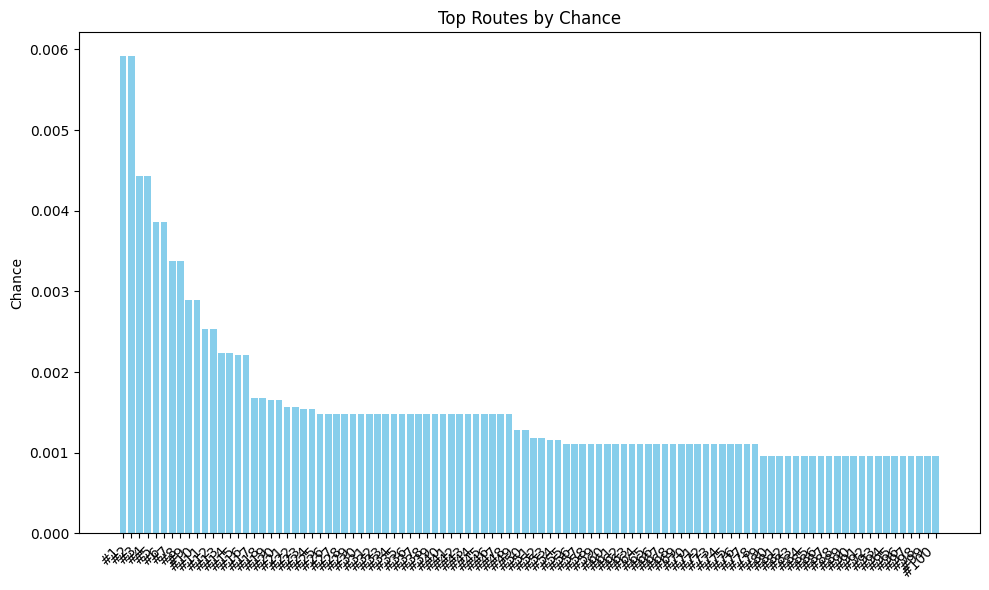

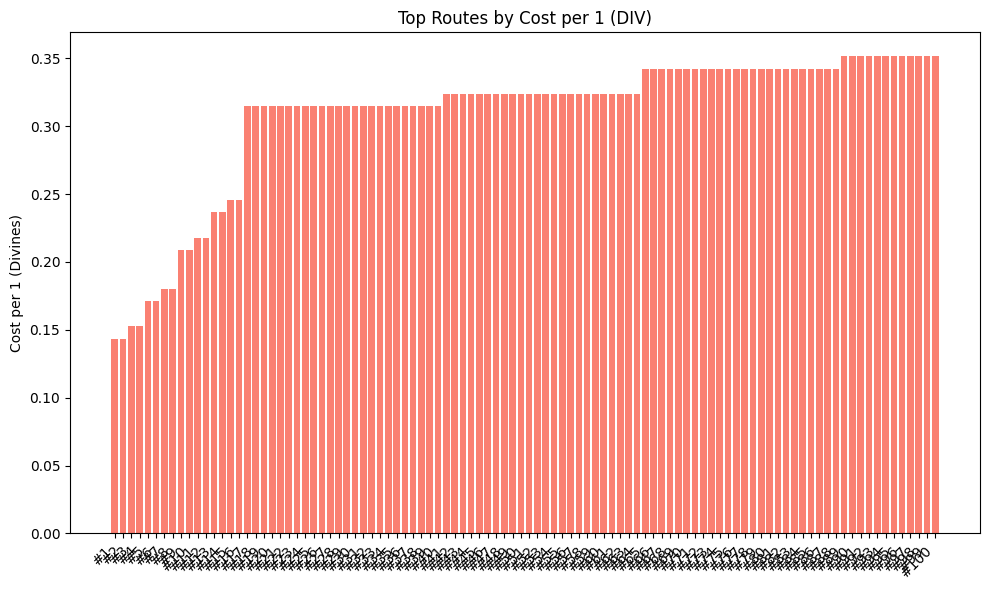

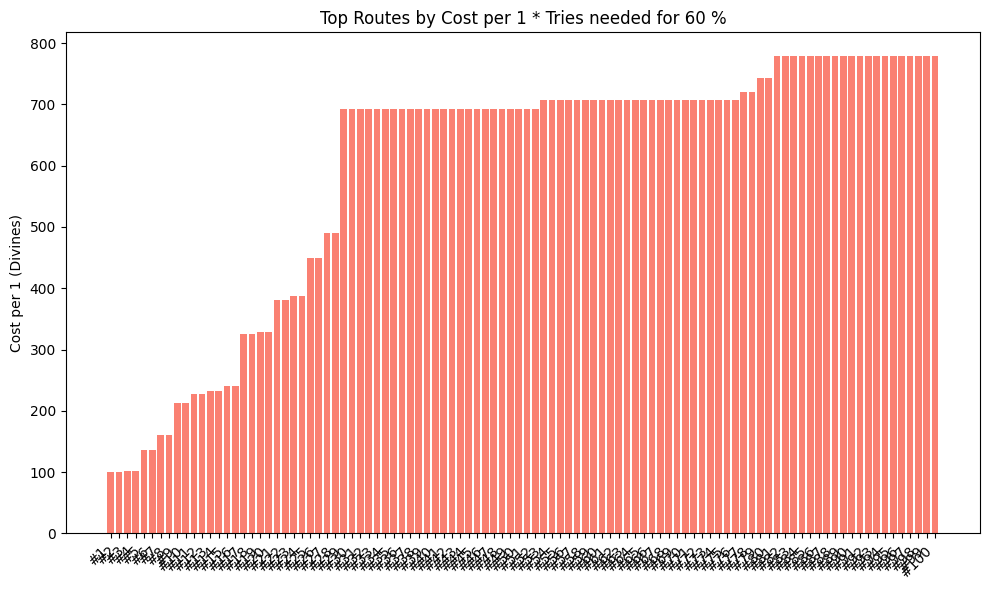

In [35]:
import matplotlib.pyplot as plt

# 14a. Top Routes by Chance
plt.figure(figsize=(10, 6))
plt.bar(df_chance['Route'], df_chance['Chance'].apply(
    lambda x: x.get_raw_value() if x else 0), color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Chance')
plt.title('Top Routes by Chance')
plt.tight_layout()
plt.show()

# 14b. Top Routes by Cost per 1 (DIV)
plt.figure(figsize=(10, 6))
plt.bar(df_cost['Route'], df_cost['Cost per 1 (DIV)'].apply(
    lambda x: x if x else 0), color='salmon')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Cost per 1 (Divines)')
plt.title('Top Routes by Cost per 1 (DIV)')
plt.tight_layout()
plt.show()

# 14c. Top Routes by Cost per 1 * by tries needed for 60 percent (DIV)
heights = df_efficiency['Cost per 1 (DIV)'] * \
    df_efficiency['Tries needed for 60 %'].apply(lambda x: x if x else 0)

plt.figure(figsize=(10, 6))
plt.bar(df_efficiency['Route'], heights, color='salmon')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Cost per 1 (Divines)')
plt.title('Top Routes by Cost per 1 * Tries needed for 60 %')
plt.tight_layout()
plt.show()

# 14d. Top Currency Groups by Chance
# plt.figure(figsize=(10, 6))
# plt.bar(df_groups['Currencies'], df_groups['Group Chance'].apply(
#     lambda x: x.get_raw_value() if x else 0), color='lightgreen')
# plt.xticks(rotation=45, ha='right')
# plt.ylabel('Group Chance')
# plt.title('Top Currency Groups by Chance')
# plt.tight_layout()
# plt.show()